In [ ]:
import os
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [2]:

def load_wav_from_subfolders(root_folder):
    wav_files = []
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.wav'):
                filepath = os.path.join(dirpath, filename)
                data, samplerate = sf.read(filepath)
                wav_files.append((filepath, data, samplerate))
    return wav_files

# Đọc file từ train và test
train_folder = 'vivos/train/waves'
test_folder = 'vivos/test/waves'

train_data = load_wav_from_subfolders(train_folder)
test_data = load_wav_from_subfolders(test_folder)

# Kiểm tra kết quả
print(f"Tổng file train: {len(train_data)}")
print(f"Tổng file test: {len(test_data)}")
print("Ví dụ file:", train_data[0][0])  # In đường dẫn file đầu tiên

Tổng file train: 11660
Tổng file test: 760
Ví dụ file: vivos/train/waves\VIVOSSPK01\VIVOSSPK01_R001.wav


In [10]:
print(train_data[0][2])  # In kích thước của dữ liệu âm thanh đầu tiên

16000


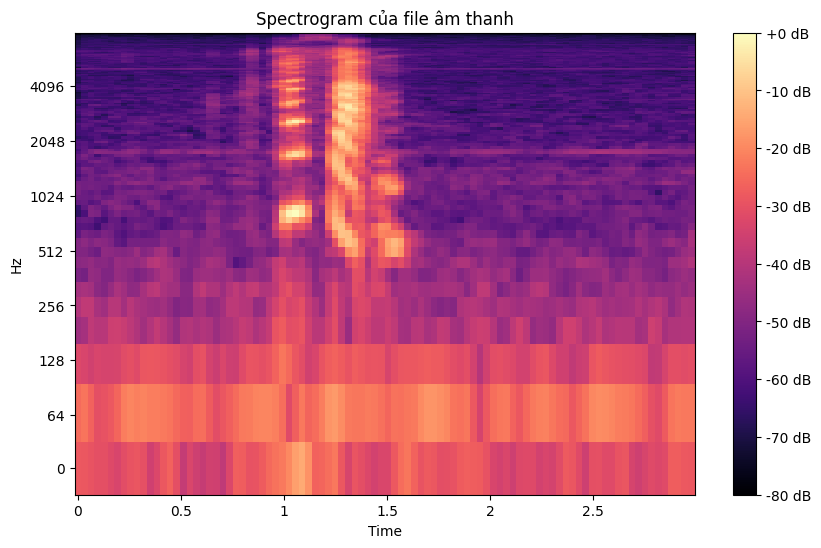

In [ ]:


# Dữ liệu âm thanh từ file đầu tiên trong train_data
audio_data = train_data[0][1]
sampling_rate = train_data[0][2]

# Tính toán Spectrogram
S = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate)

# Chuyển đổi Spectrogram sang decibel (dB) để dễ nhìn hơn
S_dB = librosa.power_to_db(S, ref=np.max)

# Vẽ Spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, x_axis='time', y_axis='log', sr=sampling_rate)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram của file âm thanh')
plt.show()
